# Introduction

Many graphs are derived from communication data over time.  Commonly, many graphs are formed from all available data, or from fixed periods of time within the data.  However, both of these techniques ignore the dynamic nature of the communication data -- who we communicate with changes over time.  For example, consider an email network at a large company.  As time goes on, employees (nodes) join and leave the company (network), and also can shift roles or teams within the company.  Each of these transitions cause shifts in the communication patterns that should be represented by the static graph snapshots derived from the communication data.

We here present the EASEE method (Edge Advertisements into Snapshots using Evolving Expectations).  EASEE directly monitors incoming communication events (edge advertisements) and analyzes how these converge to patterns and then shift from these patterns.

This notebook describes the EASEE method step-by-step.  We begin by loading the necessary Python packages and import some data.

# Code Preliminaries and Definitions

In [1]:
import EASEE_demo_prelims
from EASEE_demo_prelims import *

%matplotlib inline

In [2]:
SCRIPT_PATH = "../"

DATA_PATH = "./data/"
DATA_FILE = DATA_PATH + "euemails/TimeOrdered.csv"

OUT_PATH = "./out/"
OUT_BASE = "EASEE_out"
LOG_FILE = "EASEE_log.txt"
if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)

DATA_TIMESCALE = 1 # Value to divide timestamps by for units in seconds; EU E-Mails is in seconds
MIN_COMP = 3; # Minimum connected component size

# Data Exploration

We first load a dataset and explore some basic statistics. This is the EU E-Mails network, where email addresses are nodes and emails between addresses form edges.  Each email is an advertisement of an edge that exists.  Edge advertisements (EAs) can and often do repeat. 

Citations for the data:<br/>
Jure Leskovec, Jon Kleinberg, and Christos Faloutsos. 
“Graph evolution: Densification and shrinking diameters”.
In: ACM transactions on Knowledge Discovery from Data (TKDD) 1.1 (2007), 2–es.

Hao Yin et al. 
“Local higher-order graph clustering”. 
In: Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. 
2017, pp. 555–564.

In [3]:
# DataFrame of EAs
EA_list = pd.read_csv(DATA_FILE, header = None, names = ["node_a", "node_b", "timestamp"])

# Nodes/Edges and appearance counts
node_dist = Counter(list(EA_list["node_a"]) + list(EA_list["node_b"]))
edge_dist = Counter(list(zip(list(EA_list["node_a"]), list(EA_list["node_b"]))))

G = nx.from_pandas_edgelist(EA_list[["node_a", "node_b"]], "node_a", "node_b")
G_comp_sizes = [len(c) for c in sorted(nx.connected_components(G), key = len, reverse = True)]

print("There are " + str(len(node_dist)) + " unique nodes.")
print("There are " + str(len(edge_dist)) + " unique edges.")
print("There are " + str(len(EA_list)) + " EAs.")
print("There are " + str(len(G_comp_sizes)) + " connected components.");


There are 986 unique nodes.
There are 24929 unique edges.
There are 327336 EAs.
There are 1 connected components.


Next, we plot the node and edge appearance distribution within EAs.  That is, we count the number of times a node (or edge) appear within all EAs and plot those histograms below.  We see that most edges (and nodes) appear relatively few times, but that the distribution is long-tailed.

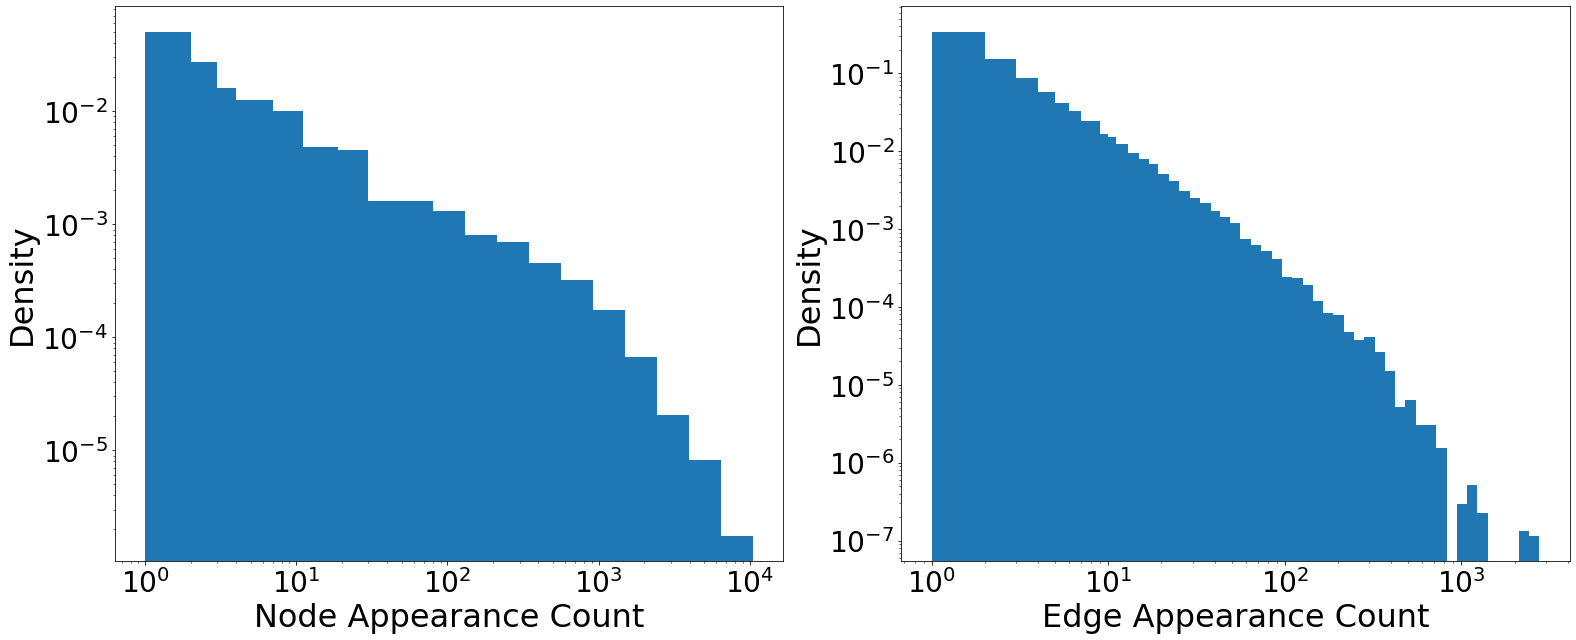

In [4]:
sr = 1
sc = 2
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

plt.subplot(sr, sc, 1)
plt.hist(node_dist.values(), bins = rice_bins(list(node_dist.values())), density = True)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Node Appearance Count")
plt.ylabel("Density")

plt.subplot(sr, sc, 2)
plt.hist(edge_dist.values(), bins = rice_bins(list(edge_dist.values())), density = True)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Edge Appearance Count")
plt.ylabel("Density")

plt.tight_layout();

# Run EASEE

We now run all EAs in order through the EASEE method. The first step of EASEE segments a stream of communication events into minimal, sufficient snapshots.  These cut points are based on "EA types" which we will define after going over some basic statistics of the resulting snapshots.

The second step goes through the resulting sufficient snapshots and considers which could be merged back together, and which should remain separate.  Again, we will dive further into this technique after going over basic statistics and the sufficient snapshot step.

EASEE is a very efficient technique.  Note that our Python implementation runs over a stream of emails representing months of interactions in only a few seconds.

In [5]:
# Run EASEE and MergeGraphs
print("Running EASEE.")
t0 = time.time()
EASEE_wrapper(DATA_FILE, SCRIPT_PATH, OUT_PATH, OUT_BASE, LOG_FILE)
t1 = time.time()
print(str(t1 - t0) + " seconds elapsed. \nRunning MergeGraphs.")
MergeGraphs_wrapper(SCRIPT_PATH, OUT_PATH, OUT_BASE + "_graph_", OUT_BASE + "_merged", "Merge_" + LOG_FILE)
t2 = time.time()
print(str(t2 - t1) + " more seconds elapsed, " + str(t2 - t0) + " total seconds. \nDone.");


Running EASEE.
8.50590705871582 seconds elapsed. 
Running MergeGraphs.
0.29349708557128906 more seconds elapsed, 8.79940414428711 total seconds. 
Done.


In [6]:
# Load EASEE log for edge type, etc data
EASEE_log_data = pd.read_csv(OUT_PATH + LOG_FILE)

# Load summary statistics of the EASEE windows/snapshots
EASEE_windows, EASEE_snapshots = load_EASEE_output(OUT_PATH, OUT_BASE + "_graph_", DATA_TIMESCALE, MIN_COMP, True)

# Create a list of time intervals for each window
window_times = [(EASEE_snapshots[x]["first_time"].min(), EASEE_snapshots[x]["last_time"].max()) 
                for x in range(len(EASEE_snapshots))]

# Load MergeGraphs results
MergeGraph_data = pd.read_csv(OUT_PATH + OUT_BASE + "_merged.similarity.csv");

## Analyze EASEE Results

We plot some statistics from each sufficient snapshot produced by EASEE. We see that the snapshots tend to have very similar statistics, e.g., size as measured by the number of nodes/edges/edge advertisements/timespan/connected compoenents, and edge behavior, as measured by statistics like the mean EAs per edge and various measures of density. 

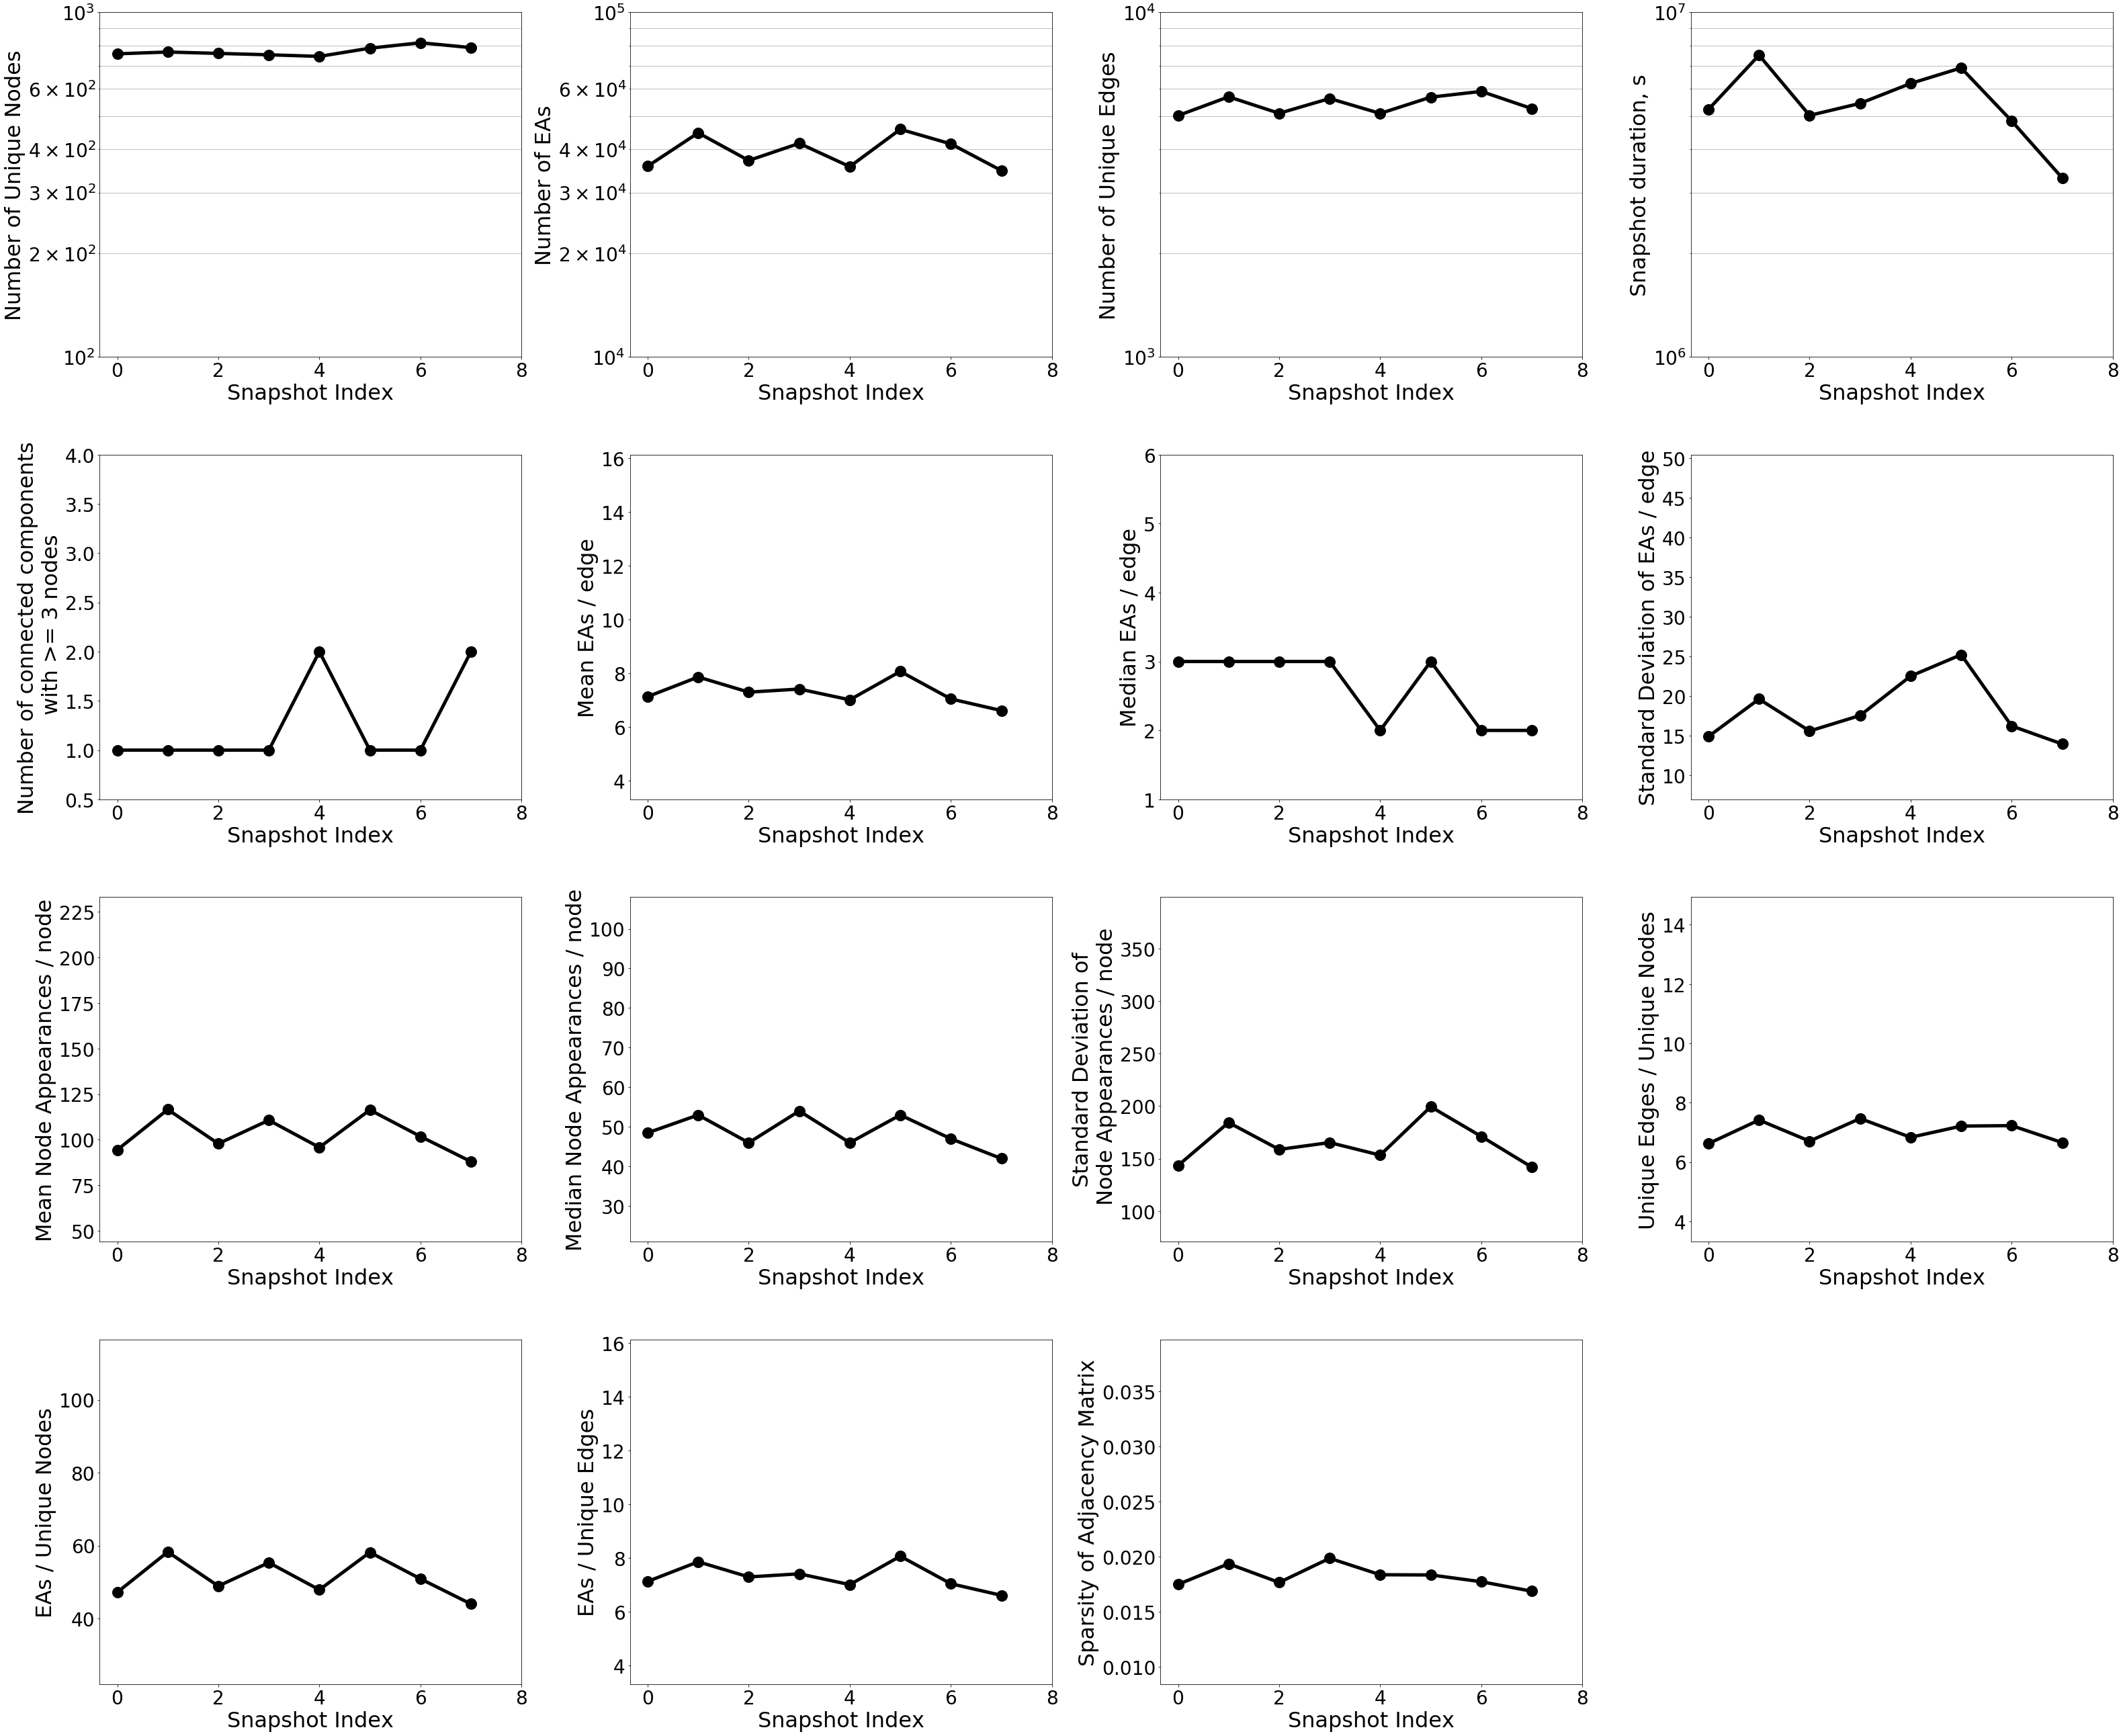

In [7]:
# Plot EASEE Data

label_dict = {"snapshot_index" : "Snapshot Index", 
     "unique_nodes" : "Number of Unique Nodes",
     "EA_count" : "Number of EAs", 
     "unique_edges" : "Number of Unique Edges",
     "timespan" : "Snapshot duration, s",
     "components" : "Number of connected components\n with >= "+ str(MIN_COMP) + " nodes",
     "EA_mean" : "Mean EAs / edge",
     "EA_median" : "Median EAs / edge",
     "EA_std" : "Standard Deviation of EAs / edge",
     "NA_mean" : "Mean Node Appearances / node",
     "NA_median" : "Median Node Appearances / node",
     "NA_std" : "Standard Deviation of\n Node Appearances / node",
     "unique_density" : "Unique Edges / Unique Nodes",
     "EA_density" : "EAs / Unique Nodes",
     "EA_ratio" : "EAs / Unique Edges",
     "possible_density" : "Sparsity of Adjacency Matrix"
}

xticks = list(np.unique(list(np.arange(0, EASEE_windows.shape[0], 2)) + [EASEE_windows.shape[0]]))
xticks_str = [str(x) for x in xticks]

sr = 4
sc = 4
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

for p_idx, y_val in enumerate(list(EASEE_windows.columns)[1:]):
    plt.subplot(sr, sc, p_idx + 1)
    
    plt.plot(EASEE_windows["snapshot_index"], EASEE_windows[y_val], color = "k", marker = "o")
    plt.xlabel(label_dict["snapshot_index"])
    plt.ylabel(label_dict[y_val])
    
    plt.grid(b = True, which = "Minor", axis = "both")
    plt.xticks(ticks = xticks, labels = xticks_str)
    
    if p_idx < 4:
        plt.yscale("log")
        plt.ylim(10.0**np.floor(np.log10(EASEE_windows[y_val].min())), 
                 10.0**np.ceil(np.log10(EASEE_windows[y_val].max())))
    else:
        plt.ylim(EASEE_windows[y_val].min() / 2, 
                 EASEE_windows[y_val].max() * 2)

plt.tight_layout();
    

We now look at the presence of nodes and edges across the snapshots.  The plots below show what proportion of the nodes (or edges) show up in what proportion of the snapshots.  Having taller bars further to the right on the x-axis means more nodes (or edges) show up in more snapshots.  More on the left, means the opposite.  In general, we see that nodes tend to appear in most or all snapshots, while edges tend to be more temporally local -- appearing in fewer snapshots. 

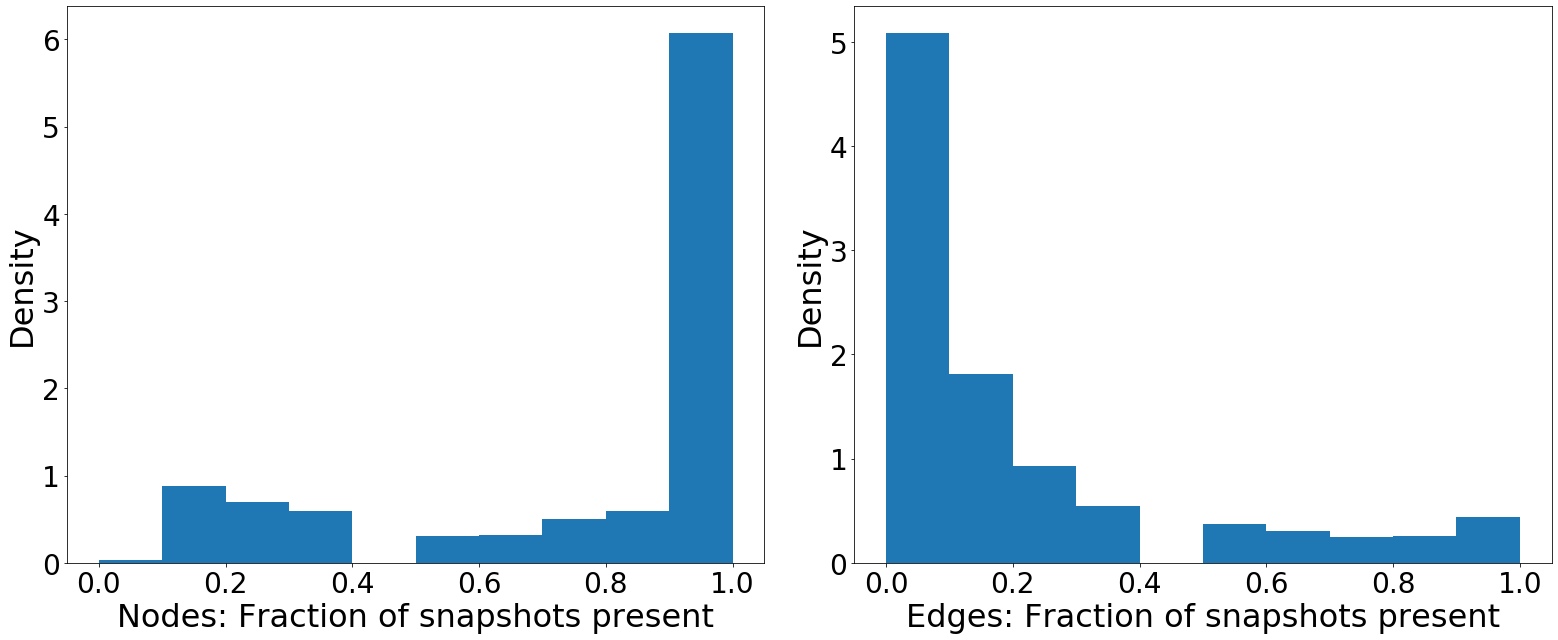

In [8]:
nodes_dict = {df : 
              set(list(EASEE_snapshots[df]["node_a"]) + list(EASEE_snapshots[df]["node_b"])) 
              for df in EASEE_snapshots}
edges_dict = {df : 
              set(zip(list(EASEE_snapshots[df]["node_a"]), list(EASEE_snapshots[df]["node_b"]))) 
              for df in EASEE_snapshots}

node_presence = {}
for node in node_dist:
    node_presence[node] = np.sum([node in nodes_dict[df] for df in nodes_dict])
    
edge_presence = {}
for edge in edge_dist:
    edge_presence[edge] = np.sum([edge in edges_dict[df] for df in edges_dict])

    
sr = 1
sc = 2
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

plt.subplot(sr, sc, 1)
plt.hist(np.asarray(list(node_presence.values())) / len(EASEE_snapshots), density = True)
plt.xlabel("Nodes: Fraction of snapshots present")
plt.ylabel("Density")

plt.subplot(sr, sc, 2)
plt.hist(np.asarray(list(edge_presence.values())) / len(EASEE_snapshots), density = True)
plt.xlabel("Edges: Fraction of snapshots present")
plt.ylabel("Density")

plt.tight_layout();

## EASEE step-by-step

First, we plot some important statistics from the EASEE output. As each EA arrives, EASEE tracks how many new nodes and new edges are included in each EA.  Thus, there are four EA Types: N2 (new edge, 2 new nodes), N1 (new edge, 1 new node), N0 (new edge, 0 new nodes), and R (repeat edge, 0 new nodes).  If the underlying communication stream is largely stationary, as you see more EAs, the number of new edges and new nodes decreases to a steady state.  EASEE traces these changes directly, and watches for one of two cases -- convergence (where the proportions of EA types are static), or sudden change (where the proportion of N2, N1, and N0 suddenly increase).  When either condition is reached, a sufficient snapshot is complete, and a new snapshot begins.  In the plots below, the red vertical lines indicate the boundaries between snapshots.  

This first set of plots show the relative percentage of recent EAs for each edge type: N2 (black), N1 (blue), N0 (green), and R (purple).

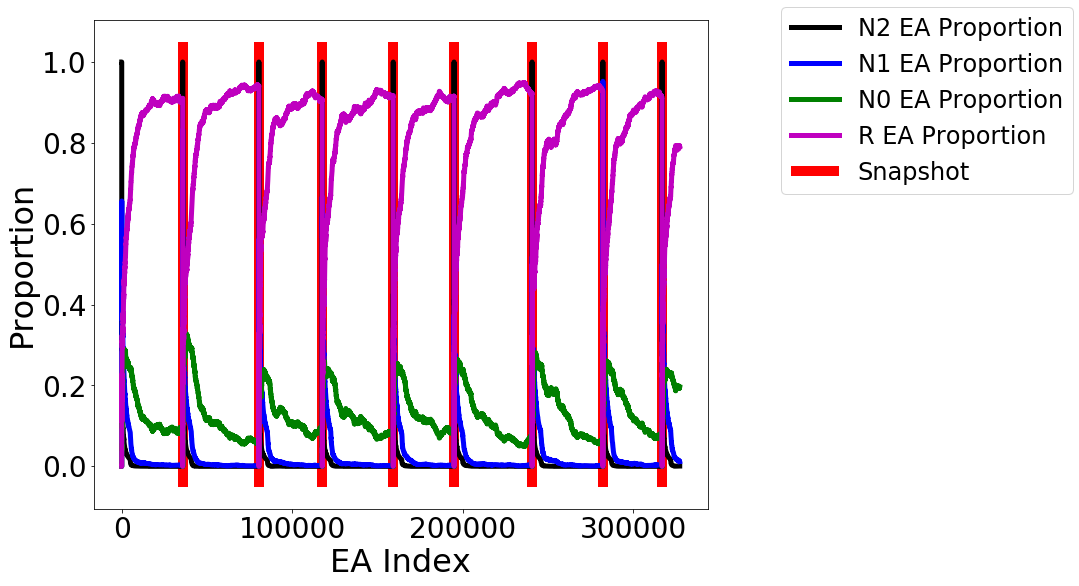

In [9]:
label_dict = {"AdvertId" : "EA Index",
    "WindowedAdPropN2" : "N2 EA Proportion",
    "WindowedAdPropN1" : "N1 EA Proportion",
    "WindowedAdPropN0" : "N0 EA Proportion",
    "WindowedAdPropR" : "R EA Proportion"
}
color_list = ["k", "b", "g", "m", "r"]
linestyle_list = ["-", "-", "-", "-", "-"]

sr = 1
sc = 1
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

plt.subplot(sr, sc, 1)
ymin = -0.05
ymax = 1.05
for p_idx, y_val in enumerate(list(label_dict.keys())[1:]):
    plt.plot(EASEE_log_data["AdvertId"], EASEE_log_data[y_val], 
             label = label_dict[y_val],
             color = color_list[p_idx], linestyle = linestyle_list[p_idx])
plt.vlines(np.cumsum(EASEE_windows["EA_count"]), 
           ymin, ymax, 
           label = "Snapshot",
           color = color_list[-1], linestyle = linestyle_list[-1], linewidth = 10)
plt.xlabel(label_dict["AdvertId"])
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor = (1.1, 1.05));


The relative proportions of these EA types can be used to predict the upcoming change in the graph size.  For instance, N2 EAs add another edge and two nodes.  In our paper, we show how to compute the expected growth of the graph given current proportions.  EASEE monitors these expected growths -- predicting 100 nodes into the future.

The plots below show the expected number of new nodes (left) and expected number of new edges (right) for this dataset.

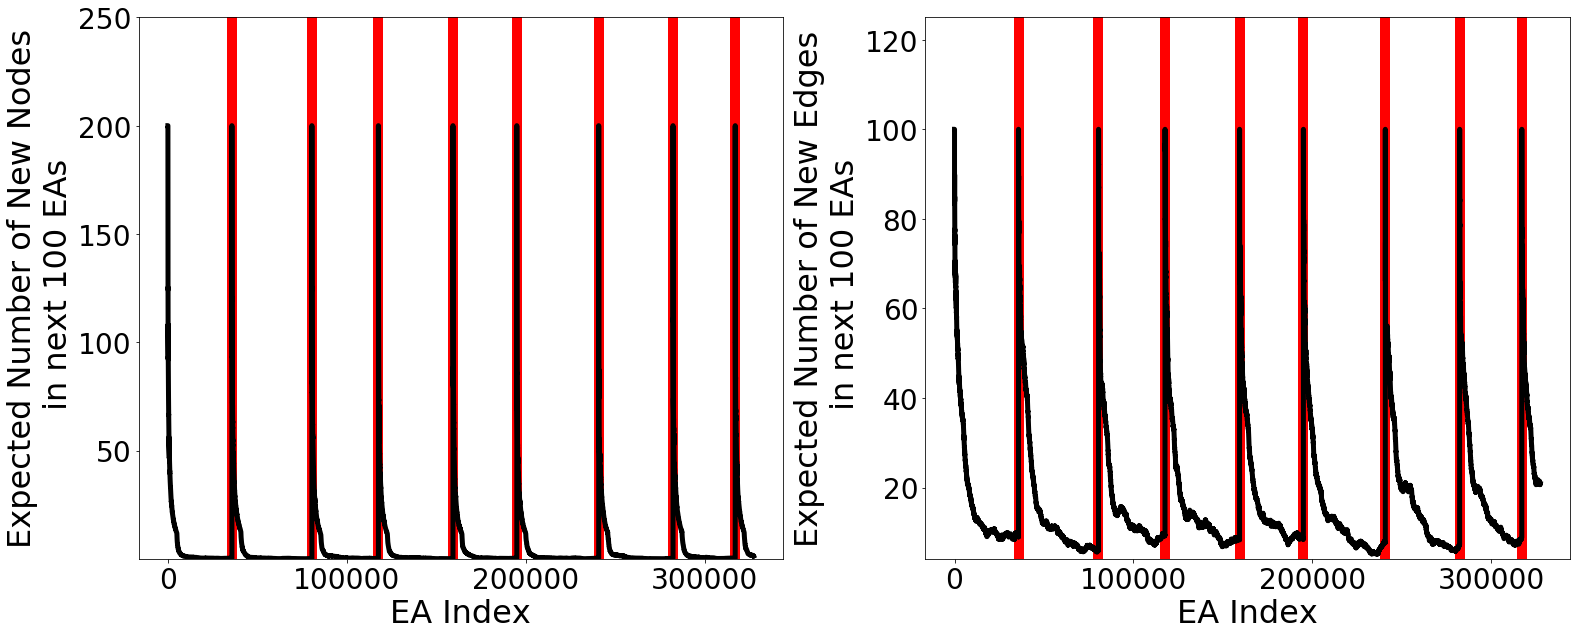

In [10]:
# Plot EASEE Data
label_dict = {"AdvertId" : "EA Index",
    "WindExpectedMoreNodesAt100" : "Expected Number of New Nodes\n in next 100 EAs",
    "WindExpectedMoreEdgesAt100" : "Expected Number of New Edges\n in next 100 EAs",
}

sr = 1
sc = 2
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

for p_idx, y_val in enumerate(list(label_dict.keys())[1:]):
    plt.subplot(sr, sc, p_idx + 1)
    
    plt.plot(EASEE_log_data["AdvertId"], EASEE_log_data[y_val], color = "k")
    
    plt.xlabel(label_dict["AdvertId"])
    plt.ylabel(label_dict[y_val])
    if EASEE_log_data[y_val].min() < 0:
        ymin = EASEE_log_data[y_val].min() * 1.25
    else:
        ymin = EASEE_log_data[y_val].min() / 1.25
    if EASEE_log_data[y_val].max() < 0:
        ymax = EASEE_log_data[y_val].max() / 1.25
    else:
        ymax = EASEE_log_data[y_val].max() * 1.25
        
    plt.vlines(np.cumsum(EASEE_windows["EA_count"]), ymin, ymax, color = "r", linewidth = 10)
    plt.ylim(ymin, ymax)
    plt.grid(b = True, which = "Minor", axis = "both")
 
plt.tight_layout();
    

Given those expected growths, EASEE measures the derivative of the growth.  When the expected number of nodes and edges is either steady (derivatives are 0), or increasing (derivatives > 0) EASEE creates a snapshot.  As this is real-world data, and noise exists, we perform some smoothing on the derivatives.

Below, we show both derivatives (nodes -- blue, edges -- black).  Both begin negative (as N2 and N1 both drop quickly), and converge near 0.  Although it can't be seen at this scale, the red cut lines occur the first time both derivatives are greater than or equal to 0.  As the derivatives spend much of their time very close to 0, on the right, we show the sign of each derivative to indicate when they are both greater than or equal to zero.

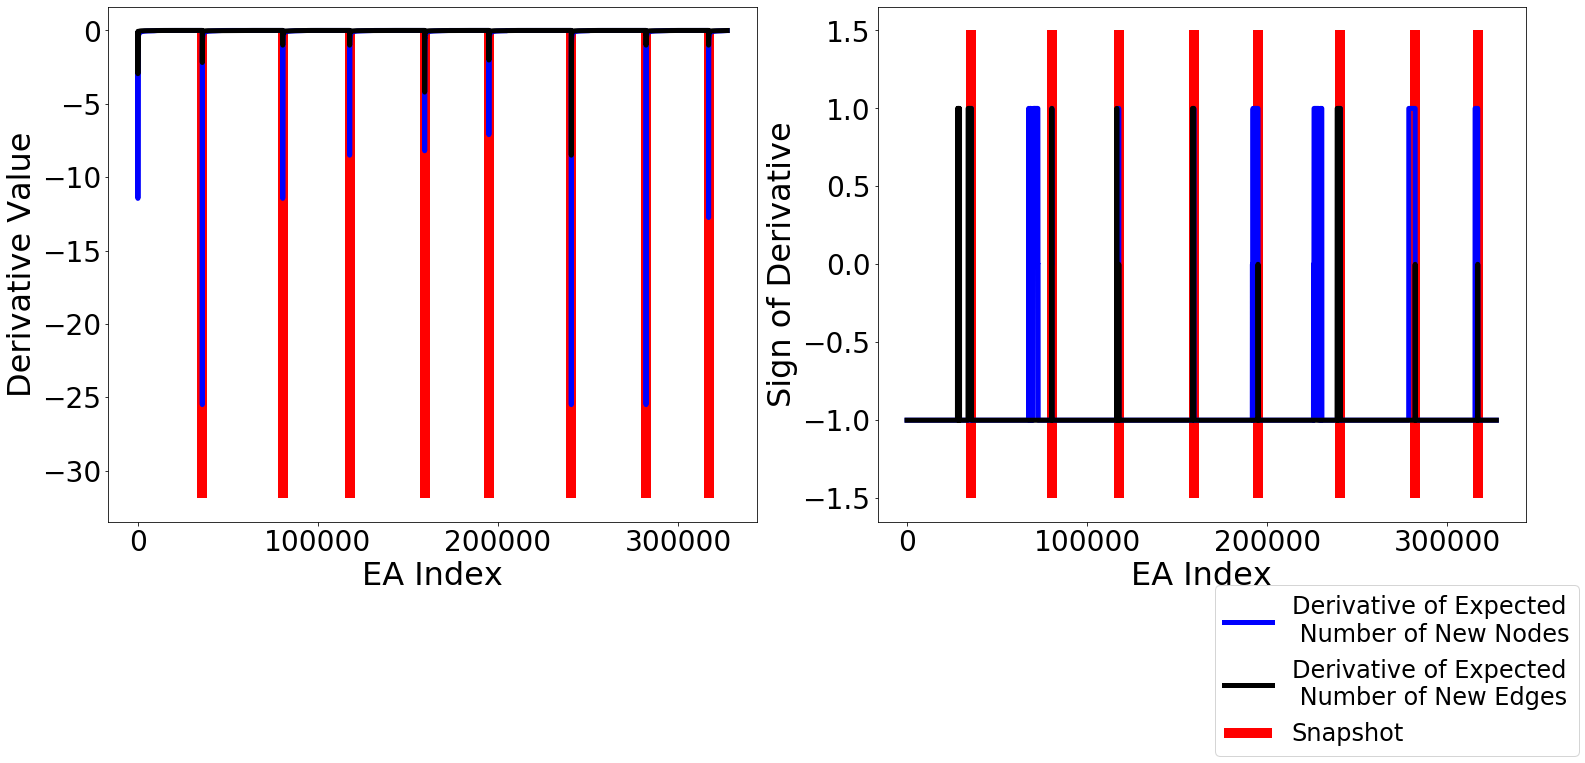

In [11]:
label_dict = {"AdvertId" : "EA Index",
    "DerivWindExpectedMoreNodesAt100" : "Derivative of Expected\n Number of New Nodes",
    "DerivWindExpectedMoreEdgesAt100" : "Derivative of Expected\n Number of New Edges",
}
color_list = ["b", "k", "r"]
linestyle_list = ["-", "-", "-"]

sr = 1
sc = 2
plt.figure(figsize = (sc * FIG_WIDTH, (sr  * 1.2) * FIG_HEIGHT))

plt.subplot(sr, sc, 1)
ymin = 1.25 * min([EASEE_log_data[y_val].min() for y_val in list(label_dict.keys())[1:]])
ymax = 1.25 * max([EASEE_log_data[y_val].max() for y_val in list(label_dict.keys())[1:]])
for p_idx, y_val in enumerate(list(label_dict.keys())[1:]):
    plt.plot(EASEE_log_data["AdvertId"], EASEE_log_data[y_val], 
             label = label_dict[y_val],
             color = color_list[p_idx], linestyle = linestyle_list[p_idx])
plt.vlines(np.cumsum(EASEE_windows["EA_count"]), 
           ymin, ymax, 
           label = "Transitions",
           color = color_list[-1], linestyle = linestyle_list[-1], linewidth = 10)
plt.xlabel(label_dict["AdvertId"])
plt.ylabel("Derivative Value")

plt.subplot(sr, sc, 2)
ymin = -1.5
ymax = 1.5
for p_idx, y_val in enumerate(list(label_dict.keys())[1:]):
    plt.plot(EASEE_log_data["AdvertId"], np.sign(EASEE_log_data[y_val]), 
             label = label_dict[y_val],
             color = color_list[p_idx], linestyle = linestyle_list[p_idx])
plt.vlines(np.cumsum(EASEE_windows["EA_count"]), 
           ymin, ymax, 
           label = "Snapshot",
           color = color_list[-1], linestyle = linestyle_list[-1], linewidth = 10)
plt.xlabel(label_dict["AdvertId"])
plt.ylabel("Sign of Derivative")
plt.legend(bbox_to_anchor = (1.1, -0.1))

plt.tight_layout();


## Zoomed-in Versions of previous plots

As each of the above gives an overview for the entire EU Emails Dataset, many details are lost.  Below, we reproduce all of the above graphs, but limit them to the first two static snapshots.

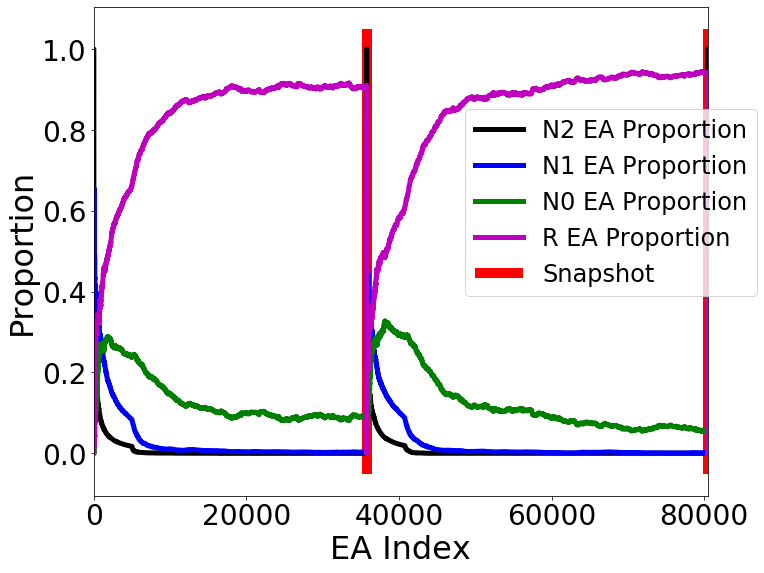

In [12]:
label_dict = {"AdvertId" : "EA Index",
    "WindowedAdPropN2" : "N2 EA Proportion",
    "WindowedAdPropN1" : "N1 EA Proportion",
    "WindowedAdPropN0" : "N0 EA Proportion",
    "WindowedAdPropR" : "R EA Proportion"
}
color_list = ["k", "b", "g", "m", "r"]
linestyle_list = ["-", "-", "-", "-", "-"]

sr = 1
sc = 1
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

plt.subplot(sr, sc, 1)
ymin = -0.05
ymax = 1.05
for p_idx, y_val in enumerate(list(label_dict.keys())[1:]):
    plt.plot(EASEE_log_data["AdvertId"], EASEE_log_data[y_val], 
             label = label_dict[y_val],
             color = color_list[p_idx], linestyle = linestyle_list[p_idx])
plt.vlines(np.cumsum(EASEE_windows["EA_count"]), 
           ymin, ymax, 
           label = "Snapshot",
           color = color_list[-1], linestyle = linestyle_list[-1], linewidth = 10)
plt.xlabel(label_dict["AdvertId"])
plt.ylabel("Proportion")
plt.xlim(0, np.cumsum(EASEE_windows["EA_count"])[1])
plt.legend(bbox_to_anchor = (1.1, 0.6));

Above, you can see some discontinuities around 5,000 EAs into the data when blue and black (especially) suddenly begin decreasing faster.  This is the point where our circular buffer used to compute EA proportions has filled and starts dropping the oldest EAs from it.  Thus, the first 4,999 EAs' proportions are computed with increasing number of EAs, but all EAs after that point use the same number of EAs.

You will notice that transition moment affects the predicted growth size below as well.

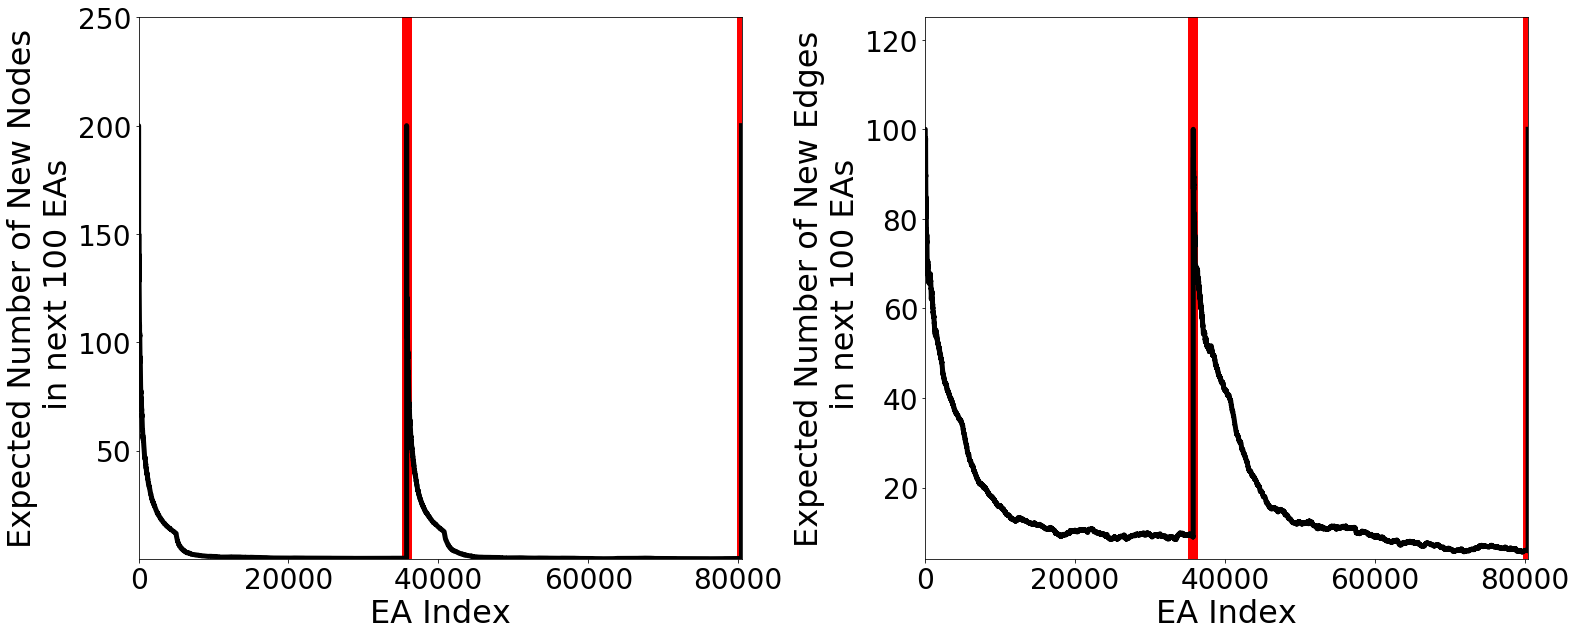

In [13]:
# Plot EASEE Data
label_dict = {"AdvertId" : "EA Index",
    "WindExpectedMoreNodesAt100" : "Expected Number of New Nodes\n in next 100 EAs",
    "WindExpectedMoreEdgesAt100" : "Expected Number of New Edges\n in next 100 EAs",
}

sr = 1
sc = 2
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

for p_idx, y_val in enumerate(list(label_dict.keys())[1:]):
    plt.subplot(sr, sc, p_idx + 1)
    
    plt.plot(EASEE_log_data["AdvertId"], EASEE_log_data[y_val], color = "k")
    
    plt.xlabel(label_dict["AdvertId"])
    plt.ylabel(label_dict[y_val])
    if EASEE_log_data[y_val].min() < 0:
        ymin = EASEE_log_data[y_val].min() * 1.25
    else:
        ymin = EASEE_log_data[y_val].min() / 1.25
    if EASEE_log_data[y_val].max() < 0:
        ymax = EASEE_log_data[y_val].max() / 1.25
    else:
        ymax = EASEE_log_data[y_val].max() * 1.25
        
    plt.vlines(np.cumsum(EASEE_windows["EA_count"]), ymin, ymax, color = "r", linewidth = 10)
    plt.ylim(ymin, ymax)
    plt.grid(b = True, which = "Minor", axis = "both")
    plt.xlim(0, np.cumsum(EASEE_windows["EA_count"])[1])

 
plt.tight_layout();
    

The derivatives of the growth require even further zooming to understand them.  Thus, on the left, we've zoomed both the x-axis (to the first two snapshots) and the y-axis (to a very tight range around zero).

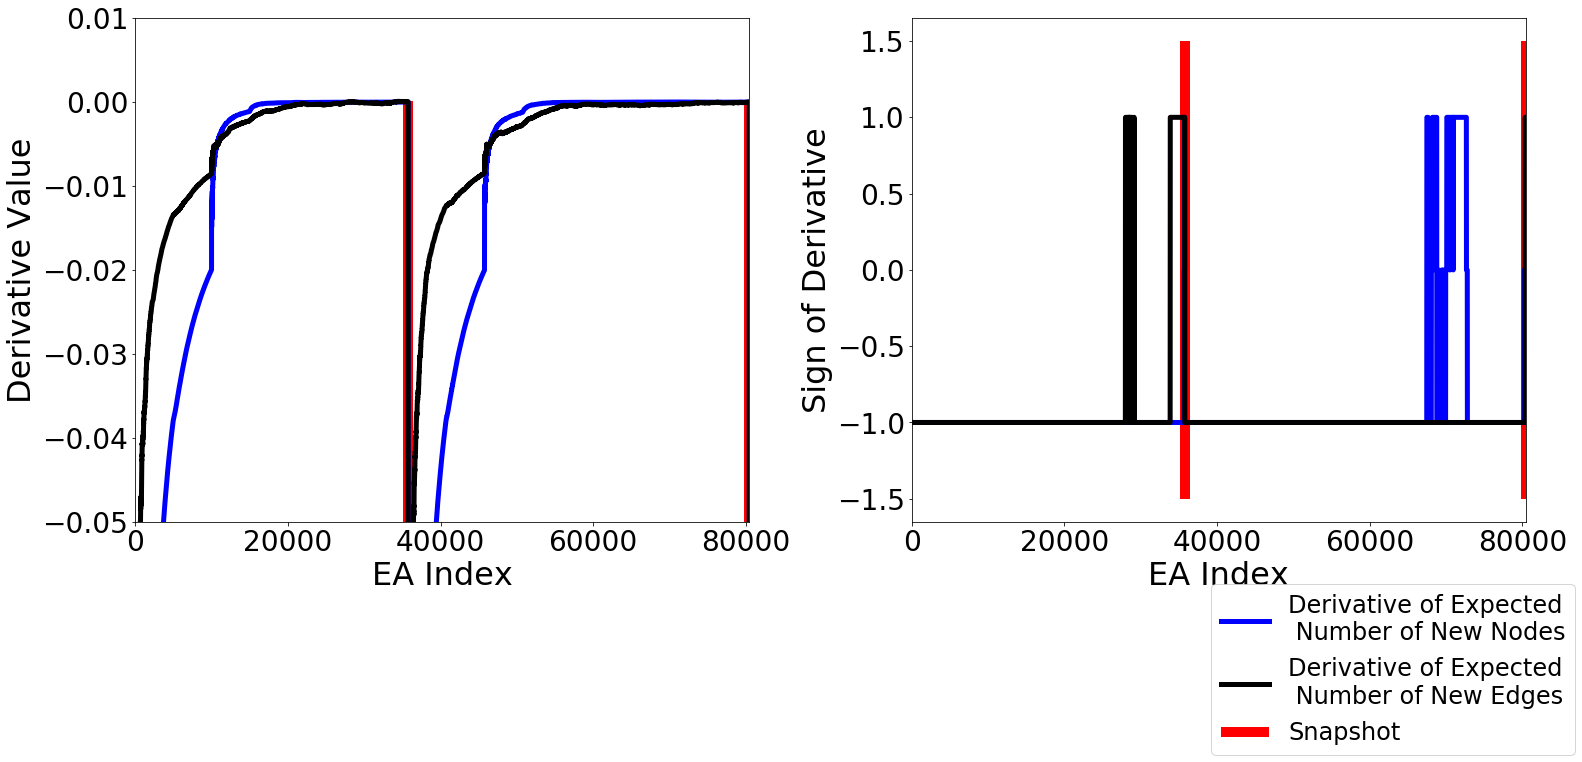

In [14]:
label_dict = {"AdvertId" : "EA Index",
    "DerivWindExpectedMoreNodesAt100" : "Derivative of Expected\n Number of New Nodes",
    "DerivWindExpectedMoreEdgesAt100" : "Derivative of Expected\n Number of New Edges",
}
color_list = ["b", "k", "r"]
linestyle_list = ["-", "-", "-"]

sr = 1
sc = 2
plt.figure(figsize = (sc * FIG_WIDTH, (sr  * 1.2) * FIG_HEIGHT))

plt.subplot(sr, sc, 1)
ymin = 1.25 * min([EASEE_log_data[y_val].min() for y_val in list(label_dict.keys())[1:]])
ymax = 1.25 * max([EASEE_log_data[y_val].max() for y_val in list(label_dict.keys())[1:]])
for p_idx, y_val in enumerate(list(label_dict.keys())[1:]):
    plt.plot(EASEE_log_data["AdvertId"], EASEE_log_data[y_val], 
             label = label_dict[y_val],
             color = color_list[p_idx], linestyle = linestyle_list[p_idx])
plt.vlines(np.cumsum(EASEE_windows["EA_count"]), 
           ymin, ymax, 
           label = "Transitions",
           color = color_list[-1], linestyle = linestyle_list[-1], linewidth = 10)
plt.xlabel(label_dict["AdvertId"])
plt.ylabel("Derivative Value")
plt.xlim(0, np.cumsum(EASEE_windows["EA_count"])[1])
plt.ylim(-0.05, 0.01)

plt.subplot(sr, sc, 2)
ymin = -1.5
ymax = 1.5
for p_idx, y_val in enumerate(list(label_dict.keys())[1:]):
    plt.plot(EASEE_log_data["AdvertId"], np.sign(EASEE_log_data[y_val]), 
             label = label_dict[y_val],
             color = color_list[p_idx], linestyle = linestyle_list[p_idx])
plt.vlines(np.cumsum(EASEE_windows["EA_count"]), 
           ymin, ymax, 
           label = "Snapshot",
           color = color_list[-1], linestyle = linestyle_list[-1], linewidth = 10)
plt.xlabel(label_dict["AdvertId"])
plt.ylabel("Sign of Derivative")
plt.xlim(0, np.cumsum(EASEE_windows["EA_count"])[1])
plt.legend(bbox_to_anchor = (1.1, -0.1))

plt.tight_layout();


## What if we don't create static snapshots?

There is some interest in how the different EA types vary if no snapshots are taken.  The below completely replicates EA type computation and a last-5,000-EA-probability calculator in a few lines of code.

In the plot below, you can clearly see that the proportions both stabilize in general, and that there are periods where the number of new nodes and edges suddenly increases for a period of time before converging back to stable.

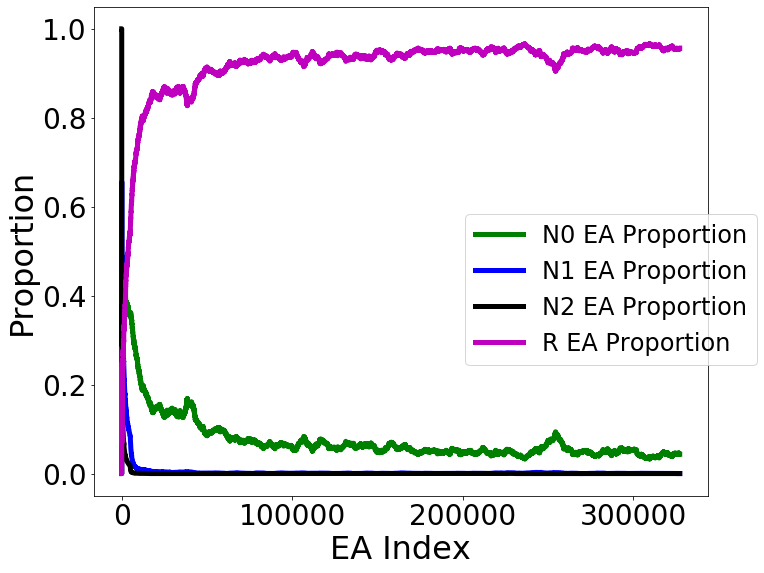

In [15]:
edge_set = set()
node_set = set()
prob_tracker = np.zeros((EA_list.shape[0], )) # N0, N1, N2, R is 0 -> 3

# Compute the EA type for each EA in the entire list of emails
for idx, e in enumerate(zip(list(EA_list["node_a"]), list(EA_list["node_b"]))):
    n1 = e[0]
    n2 = e[1]
    if e in edge_set: # R
        prob_tracker[idx] = 3
    elif (n1 not in node_set) and (n2 not in node_set): # N2
        prob_tracker[idx] = 2
    elif (n1 in node_set) and (n2 not in node_set): # N1
        prob_tracker[idx] = 1
    elif (n1 not in node_set) and (n2 in node_set): # N1
        prob_tracker[idx] = 1   
    elif (n1 in node_set) and (n2 in node_set): # N0
        prob_tracker[idx] = 0
    node_set.add(n1)
    node_set.add(n2)
    edge_set.add(e)

# Compute the EA proportion for the most recent 5K EAs
prob_values = np.zeros((EA_list.shape[0], 4)) # N0, N1, N2, R is 0 -> 3
# First, compute the cumulative sum
for val in range(4):
    prob_values[:, val] = np.cumsum(prob_tracker == val)
# Second, keep only the most recent 5,000 and compute the relative proportions
# Note that we have to start from the right and compute to the left (as we're using 
# earlier values when computing the later values)
for idx in range(EA_list.shape[0]-1, -1, -1):
    sum_total = 0
    for val in range(4):
        # Take only the most recent 5,000
        if idx > 5000:
            prob_values[idx, val] -= prob_values[idx-5000, val]
        sum_total += prob_values[idx, val]
    for val in range(4):
        prob_values[idx, val] /= sum_total

color_list = ["g", "b", "k", "m"]
linestyle_list = ["-", "-", "-", "-"]
labels = ["N0 EA Proportion",
            "N1 EA Proportion",
            "N2 EA Proportion",
            "R EA Proportion"]

sr = 1
sc = 1
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

plt.subplot(sr, sc, 1)
ymin = -0.05
ymax = 1.05
for p_idx in range(4):
    plt.plot(EASEE_log_data["AdvertId"], prob_values[:, p_idx], 
             label = labels[p_idx],
             color = color_list[p_idx], linestyle = linestyle_list[p_idx])
plt.xlabel("EA Index")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor = (1.1, 0.6));

# MergeGraphs Analysis

We now examine the second part of EASEE -- merging sufficient snapshots.  Although EASEE uses cosine similarity for this analysis, we also show Jaccard similarity for comparison.  Herein, we apply cosine and Jaccard to the number of times each edge or node appears in an EA in each snapshot. 

We see that node similarities are generally higher than edge similarities.  Moreover, the edge cosine similarity appears to offer the strongest variability, while Jaccard similarity is generally lower and with less variability. 

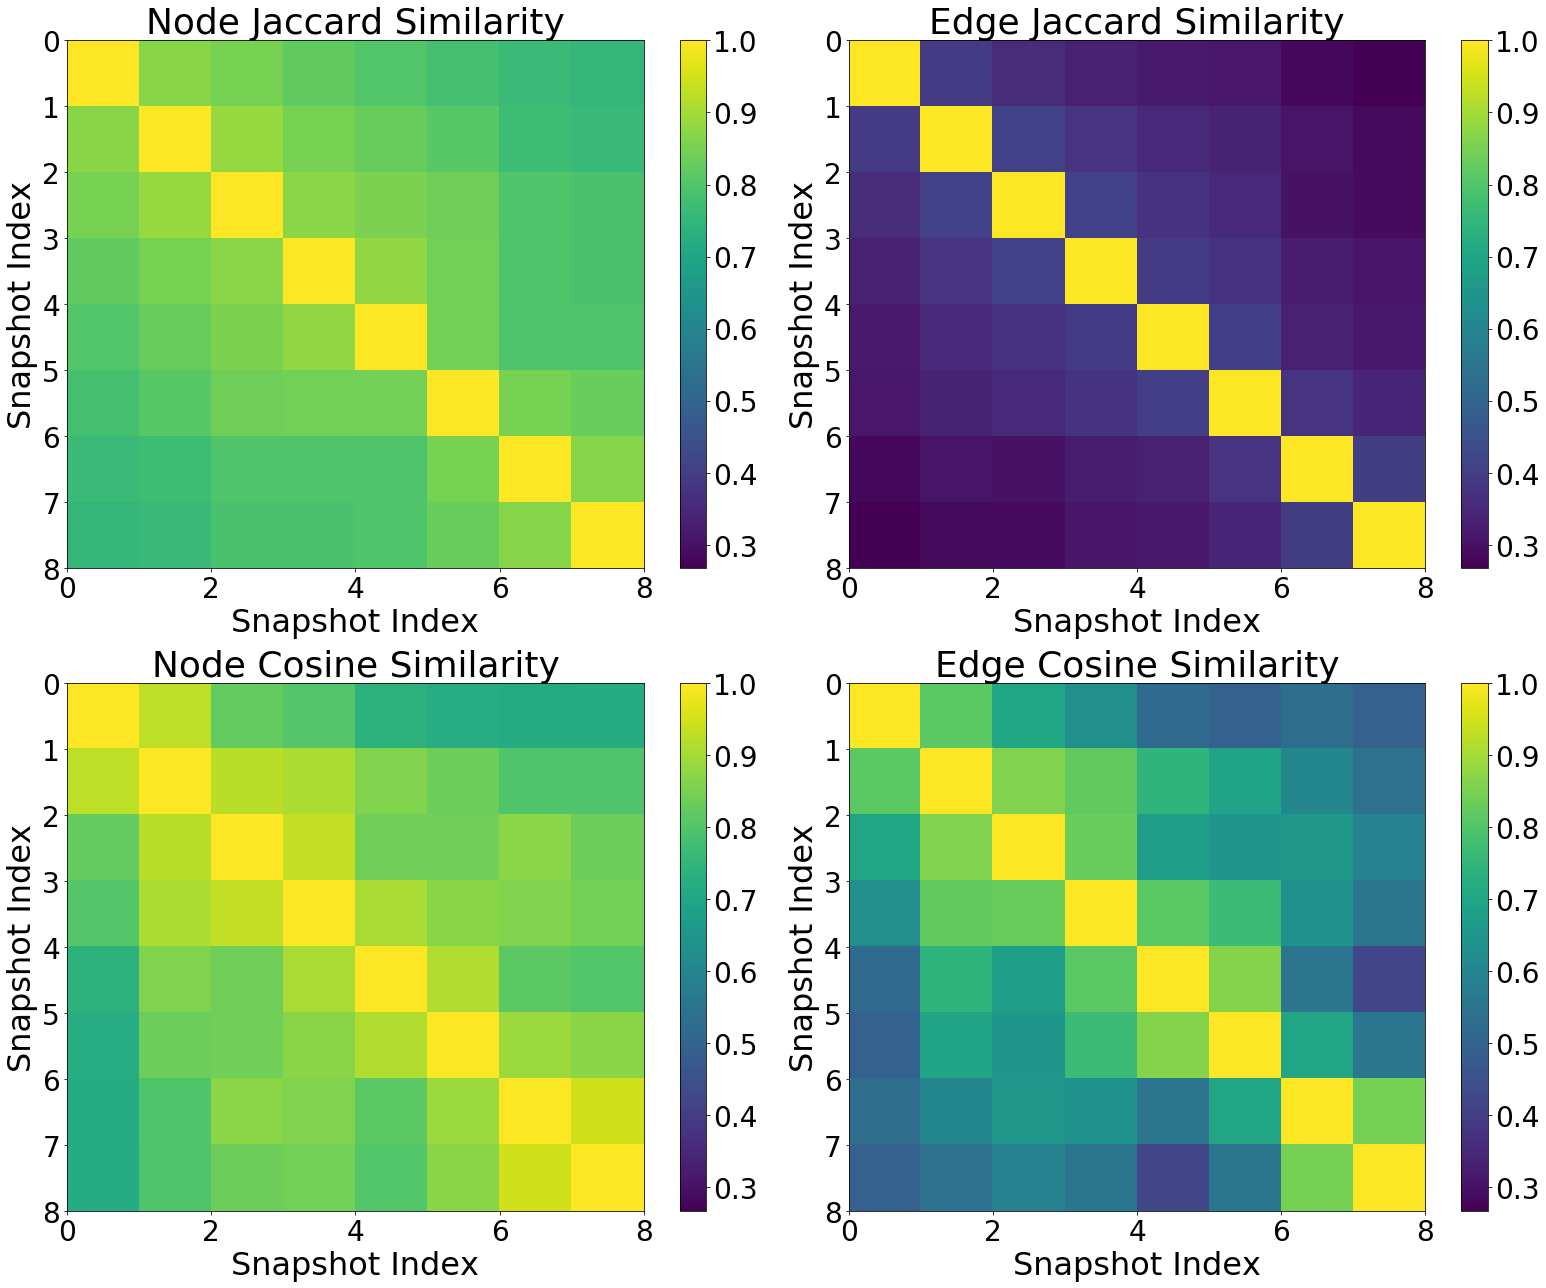

In [16]:
label_dict = {"nodes_jaccard" : "Node Jaccard Similarity", 
              "edges_jaccard" : "Edge Jaccard Similarity",
              "nodes_cosine" : "Node Cosine Similarity", 
              "edges_cosine" : "Edge Cosine Similarity"}

sr = 2
sc = 2
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))

c_min = min([pd.pivot(MergeGraph_data, index = "id_x", columns = "id_y", values = label).min().min() 
     for label in label_dict])
c_max = max([pd.pivot(MergeGraph_data, index = "id_x", columns = "id_y", values = label).max().max() 
     for label in label_dict])
for p_idx, label in enumerate(label_dict):
    plt.subplot(sr, sc, p_idx + 1)
    plt.pcolormesh(pd.pivot(MergeGraph_data, index = "id_x", columns = "id_y", values = label))
    plt.gca().invert_yaxis()
    plt.clim(c_min, c_max)
    plt.colorbar()
    plt.xlabel("Snapshot Index")
    plt.ylabel("Snapshot Index")
    plt.title(label_dict[label])

plt.tight_layout();




Because of its greater contrast, we focus on edge cosine similarity for the remaining analyses. To decide whether to combine two snapshots, we need a threshold, that is, a threshold above which we deem groups fo snapshots to be similar enough to combine.  We begin by performing a brute-force sweep over possible thresholds. 

We indicate the merged groups with red-outlined squares, and see that a threshold of approximately $0.7$ seems like a reasonable choice when looking both at the produced snapshots as well as the number of merged snapshots as a function of the threshold. Note that we merge snapshots sequentially: for example, after the third snapshot is created, if the first three snapshots are all (in every pairwise comparison) similar above the threshold (all yellow here), we merge these three. However, if the second through fourth snapshots are pairwise similar, but the first and fourth are not, we do not merge the first four or the second through fourth.

The thresholds chosen below are simply the distinct values seen in the cosine similarities of all edges.  Yellow squares indicate that the pair of snapshots are above the threshold.  Purple is below.

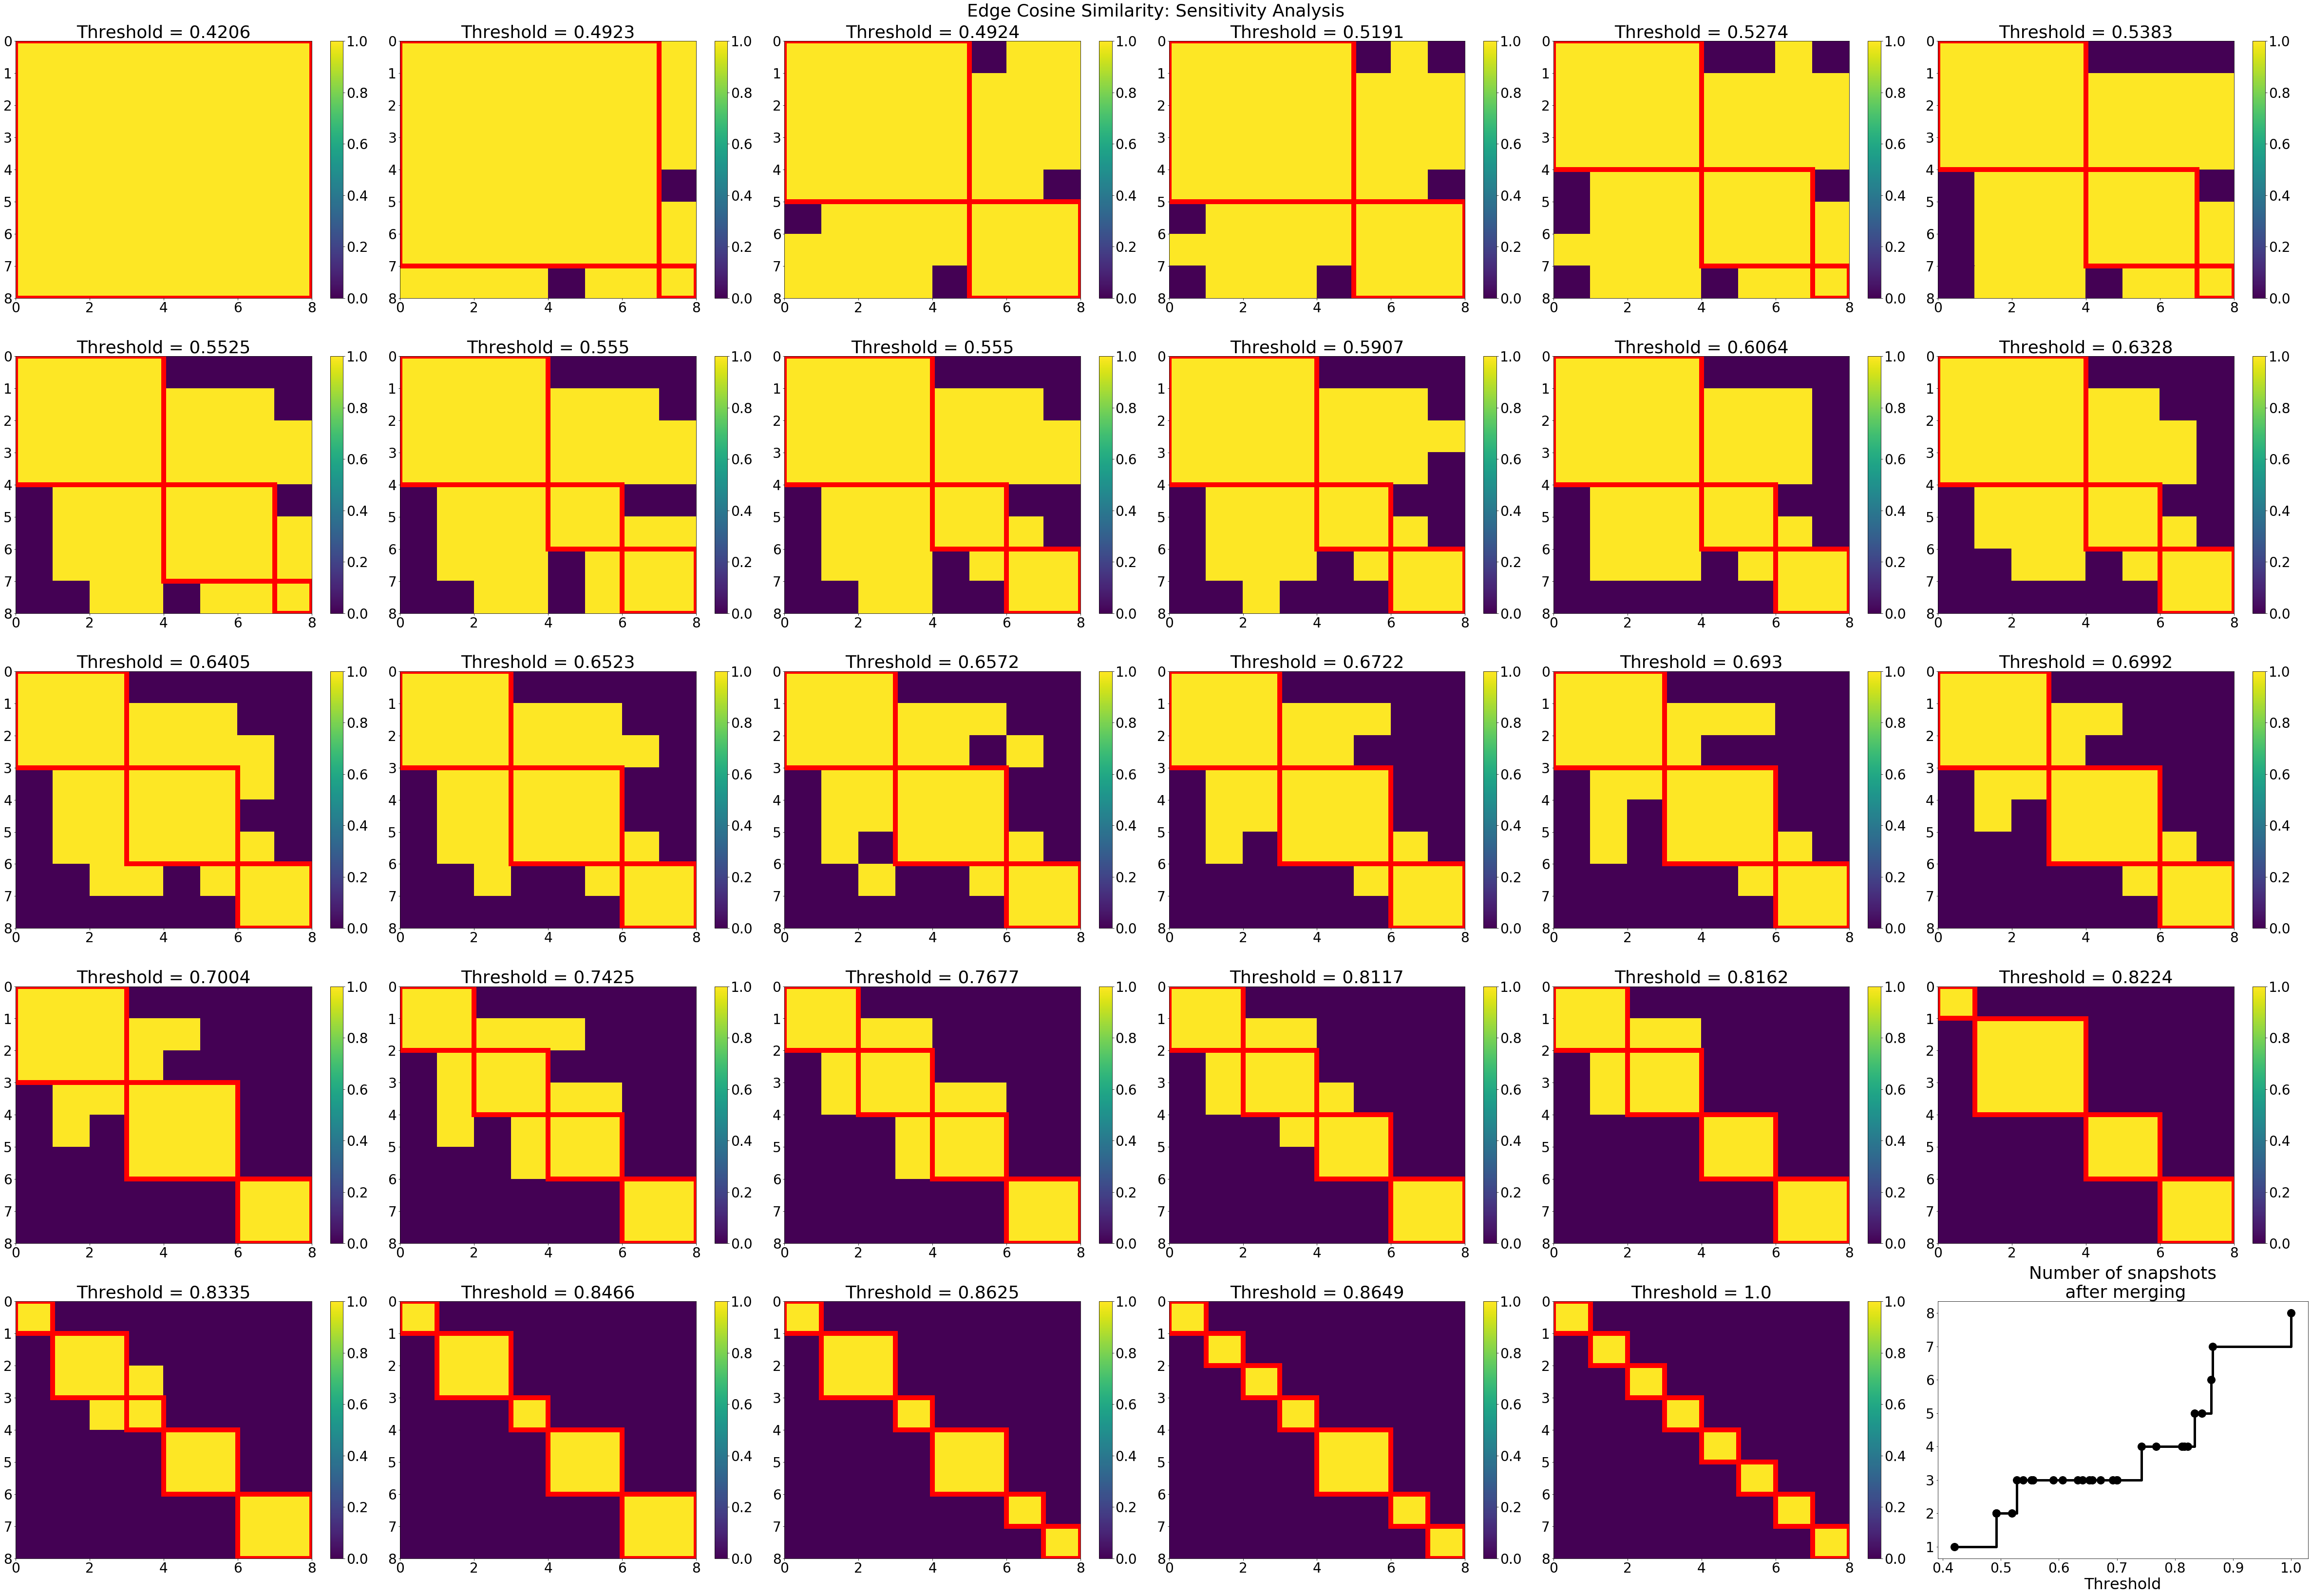

In [17]:
sim_mat = pd.pivot(MergeGraph_data, index = "id_x", columns = "id_y", values = "edges_cosine")
thresholds = np.unique(np.asarray(sim_mat))

sr = 5
sc = 6
plt.figure(figsize = (sc * FIG_WIDTH, sr * FIG_HEIGHT))
plt.suptitle("Edge Cosine Similarity: Sensitivity Analysis", y = 1.01)
for t_idx, thresh in enumerate(thresholds):
    groups = find_merge_groups(np.asarray(sim_mat), thresh)

    plt.subplot(sr, sc, t_idx + 1)
    plt.pcolormesh(sim_mat >= thresh)
    
    # Draw groups on figure
    currentAxis = plt.gca()
    for gr in groups:
        currentAxis.add_patch(Rectangle((min(gr), min(gr)), 
                                        max(gr) - min(gr) + 1,
                                        max(gr) - min(gr) + 1, 
                                        alpha = 1, fill = False, color = "r", linewidth = 10))

    plt.gca().invert_yaxis()
    plt.clim(0, 1)
    plt.colorbar()
    plt.title("Threshold = " + str(np.round(thresh, decimals = 4)))

plt.subplot(sr, sc, len(thresholds) + 1)
plt.step(thresholds, [len(find_merge_groups(np.asarray(sim_mat), t)) for t in thresholds], 
        label = "Number of Groups", color = "k", marker = "o", where = "post")
plt.yticks(ticks = np.arange(1, sim_mat.shape[0] + 1))
plt.title("Number of snapshots\n after merging")
plt.xlabel("Threshold")

plt.tight_layout();

For completeness, we now replicate the edge cosine similarity values with the red box showing which snapshots would be merged for a threshold of 0.7.

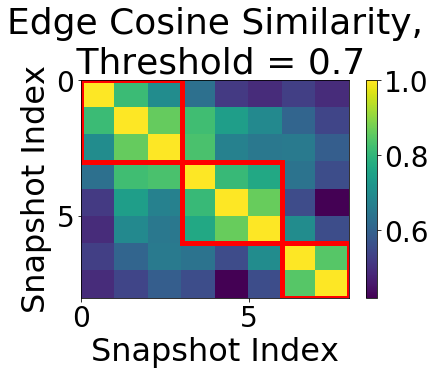

In [18]:
thresh = 0.7
groups = find_merge_groups(np.asarray(sim_mat), thresh)

plt.pcolormesh(pd.pivot(MergeGraph_data, index = "id_x", columns = "id_y", values = "edges_cosine"))
currentAxis = plt.gca()
for gr in groups:
    currentAxis.add_patch(Rectangle((min(gr), min(gr)), 
                                    max(gr) - min(gr) + 1,
                                    max(gr) - min(gr) + 1, 
                                    alpha = 1, fill = False, color = "r", linewidth = 5))
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel("Snapshot Index")
plt.ylabel("Snapshot Index")
plt.title("Edge Cosine Similarity,\n Threshold = " + str(thresh));